# R&S ZNB/ZNBT VNA - Measure test program

- **Author:** Juan del Pino Mena
- **Version:** v01
- **Date:** 2024-02-13


---

# Introduction

This program shows the configuration and data request commands sent to the VNA in order to retrieve measurement data in an efficient way. It also saves the data into an s2p touchstone file.

## Requirements

- `numpy`: For vector manipulation
- `matplotlib`: For plotting data
- `socketscpi`: For communication with SCPI commands over sockets.
    - docs: https://socketscpi.readthedocs.io/en/latest/index.html
    - original repo: https://github.com/morgan-at-keysight/socketscpi
    - backup fork: https://github.com/dpmj/socketscpi

Execute this notebook on a virtual environment for safety: https://medium.com/@royce963/setting-up-jupyterlab-and-a-virtual-environment-c79002e0e5f7


## VNA network interface configuration

1. Connect the function generator and your PC to the same local network. **They even can be connected directly via an Ethernet cable.**
2. Make sure you are connected to the same LAN as the VNA, and that they have compatible IP addresses. To check your IP, type `ipconfig` (windows), or `ifconfig` // `ip addr` (linux).
3. For convenience, this guide sets a fixed IP to the VNA.
4. Check if the device is accessible: Do a ping to the device: `ping 10.10.0.152` (windows & linux).


## Fixed IP setup on the VNA

**By default, the R&S VNA has address `10.10.0.152`, with mask `/8`.** Changing the IP is possible but requires an admin password. **In this document, this IP is not changed** If needed, follow these steps:

1. Press the windows key
2. Control panel >> Network and sharing center >> Change adapter settings >> local connection (right click) >> Properties
3. Connection properties >> Internet Protocol Version 4 (TCP/IPv4) >> Properties
4. Enter the IP configuration
5. The port for programming the VNA shall be always `5025`

## Fixed IP setup on your PC

- On Linux:
    `sudo ip addr add 10.10.0.151/8 dev enp3s0` (CHANGE `enp3s0` ACCORDING TO THE NAME OF YOUR ETHERNET INTERFACE)
- On Windows: similar steps as in the VNA.

## Calibration

Ensure the VNA is properly calibrated before measuring. There shall be a calibration file already available and suitable on the VNA. Go to CAL >> USE CAL >> CAL MANAGER. In the Pool (right window), select "Reconf-Filter-2-6G-201". Contains the calibration data for a 2-to-6 GHz bandwidth with 201 points per trace using the Agilent 85052C calibration kit. Once selected, click "Apply" on the center of the screen.

## Known problems

When using the `socketscpi` package, this error may appear on screen:

    Remote error -113: Undefined header;
    syst:err:verbose 1

This is due an internal command `socketscpi` sends to the VNA trying to explain other errors. This is not important and can be ignored. To avoid this, set `verboseErrCheck=False` when calling `socketscpi.SocketInstrument()`. See below.

---

# Program & measurement config

In [2]:
# Import dependencies. Install any missing dependencies with pip/conda inside the virtual environment

import time
import socketscpi
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Parameters - global variables

HOST = "10.10.0.152"  # [str] Instrument IP address. Default: "10.10.0.152"
PORT = 5025  # [int] Instrument listening port. Default: 5025
TIMEOUT = 10  # [s] How many seconds to wait for a response. Default: 10

F_MIN = 2e9  # [Hz] Default: 2e9 (2 GHz)
F_MAX = 6e9  # [Hz] Default: 6e9 (6 GHz)
N_POINTS = 201  # Number of measurement points

FREQ = np.linspace(F_MIN, F_MAX, N_POINTS)  # Frequency vector, for plotting

# Functions

In [4]:
def vna_setup():
    """
    Performs a reset and setups the VNA with default known parameters. 
    """
    
    vna = socketscpi.SocketInstrument(ipAddress=HOST, 
                                      port=PORT, 
                                      timeout=TIMEOUT, 
                                      verboseErrCheck = False)
    
    print(vna.instId)  # Identifies the instrument
    
    # ####################################################################################
    # Reset

    vna.write("*RST")  # Reset
    vna.write("INIT:CONT:ALL OFF")  # Disables continuous mode even for new traces
    vna.write("CALC:PAR:DEL:ALL")  # Delete all traces, blanks screen
    vna.write("*WAI")  # Waits until completed before proceeding with next command

    # ####################################################################################
    # Establishes start, stop and number of points
    
    vna.write('SENS:FREQ:STAR ' + str(F_MIN))  # Set lower frequency bound
    vna.write('SENS:FREQ:STOP ' + str(F_MAX))  # Set upper frequency bound
    vna.write('SENS:SWE:POIN ' + str(N_POINTS))  # Set number of points per trace
    vna.write("*WAI")  # Waits until completed before proceeding with next command

    # ####################################################################################
    # Creates new traces and measurements. Pag 864
    # Channel 1 (CALC1, number omitted). Measures magnitude in dB and phase in degrees
    
    vna.write("CALC:PAR:SDEF 'Trc1_mlog', 'S11'")
    vna.write("CALC:PAR:SEL 'Trc1_mlog'")
    vna.write("CALC:FORM MLOG")  # MLOG: Magnitude,dB. Pag 807
    
    vna.write("CALC:PAR:SDEF 'Trc1_phas', 'S11'")
    vna.write("CALC:PAR:SEL 'Trc1_phas'")
    vna.write("CALC:FORM PHAS")  # PHAS: Phase,deg. Pag 807
    
    vna.write("CALC:PAR:SDEF 'Trc2_mlog', 'S12'")
    vna.write("CALC:PAR:SEL 'Trc2_mlog'")
    vna.write("CALC:FORM MLOG")
    
    vna.write("CALC:PAR:SDEF 'Trc2_phas', 'S12'")
    vna.write("CALC:PAR:SEL 'Trc2_phas'")
    vna.write("CALC:FORM PHAS")
    
    vna.write("CALC:PAR:SDEF 'Trc3_mlog', 'S21'")
    vna.write("CALC:PAR:SEL 'Trc3_mlog'")
    vna.write("CALC:FORM MLOG")
    
    vna.write("CALC:PAR:SDEF 'Trc3_phas', 'S21'")
    vna.write("CALC:PAR:SEL 'Trc3_phas'")
    vna.write("CALC:FORM PHAS")
    
    vna.write("CALC:PAR:SDEF 'Trc4_mlog', 'S22'")
    vna.write("CALC:PAR:SEL 'Trc4_mlog'")
    vna.write("CALC:FORM MLOG")
    
    vna.write("CALC:PAR:SDEF 'Trc4_phas', 'S22'")
    vna.write("CALC:PAR:SEL 'Trc4_phas'")
    vna.write("CALC:FORM PHAS")
    
    vna.write("*WAI")  # Waits until completed before proceeding with next command
    
    # ####################################################################################
    # Display traces on the screen. Single sweep (only one measurement)
    
    vna.write("DISP:WIND1:STAT ON")  # Turn on window 1
    
    vna.write("DISP:WIND1:TRAC1:FEED 'Trc1_mlog'")  # Add traces
    vna.write("DISP:WIND1:TRAC2:FEED 'Trc2_mlog'")
    vna.write("DISP:WIND1:TRAC3:FEED 'Trc3_mlog'")
    vna.write("DISP:WIND1:TRAC4:FEED 'Trc4_mlog'")
    
    vna.write("DISP:WIND1:TRAC5:FEED 'Trc1_phas'")
    vna.write("DISP:WIND1:TRAC6:FEED 'Trc2_phas'")
    vna.write("DISP:WIND1:TRAC7:FEED 'Trc3_phas'")
    vna.write("DISP:WIND1:TRAC8:FEED 'Trc4_phas'")
    
    vna.write("INIT:IMM; *WAI")  # Perform a single sweep and wait until completed

    # ####################################################################################
    # Set data format - Swapped byte order, float32.
    
    vna.write('format:border swap')  # Swapped byte order
    vna.write('format real,32')  # 32-bit precision float
    vna.write("*WAI")  # Waits until completed before proceeding with next command

    # ####################################################################################
    # Check errors. Close socket.
    
    vna.err_check()
    vna.close()

In [5]:
def vna_measure_once():
    """
    Performs a sweep and measure all data. Returns the measurement as a matrix.
    """
    
    vna = socketscpi.SocketInstrument(ipAddress=HOST, 
                                      port=PORT, 
                                      timeout=TIMEOUT, 
                                      verboseErrCheck = False)
    
    vna.write("INIT:IMM; *WAI")  # Perform a single sweep and wait until completed
    
    vna.write('format:border swap')  # Swapped byte order
    vna.write('format real,32')  # 32-bit precision float
    vna.write("*WAI")  # Waits until completed before proceeding with next command
    
    data = vna.query_binary_values('CALC:DATA:ALL? FDAT', datatype='f')
    
    vna.err_check()
    vna.close()

    meas = data.reshape(8, N_POINTS)  # Reshape: 8 columns, of N_POINTS rows.
    
    return meas

In [6]:
def plot_measurement(measurement):
    """
    Plots data (in the expected 8-column, of N_POINTS-row format.)
    """

    fig, (ax1, ax2) = plt.subplots(2, figsize=[12, 10])
    
    fig.suptitle("Data retrieved from VNA - Magnitude and phase")
    ax1.set_title('Data - Magnitude')
    # ax1.set_xlabel('Freq (Hz)')
    ax1.set_ylabel('Magnitude (dB)')
    ax2.set_title('Data - Phase')
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('Phase (º)')
    
    ax1.plot(FREQ, measurement[0][:], label="Trc1,S11,mlog")
    ax1.plot(FREQ, measurement[2][:], label="Trc2,S21,mlog")
    ax1.plot(FREQ, measurement[4][:], label="Trc3,S12,mlog")
    ax1.plot(FREQ, measurement[6][:], label="Trc4,S22,mlog")
    
    ax1.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.8)
    ax1.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    ax1.minorticks_on()
    ax1.legend(loc="center right")
    
    plt.plot(FREQ, measurement[1][:], label="Trc1,S11,phas")
    plt.plot(FREQ, measurement[3][:], label="Trc2,S21,phas")
    plt.plot(FREQ, measurement[5][:], label="Trc3,S12,phas")
    plt.plot(FREQ, measurement[7][:], label="Trc4,S22,phas")
    
    ax2.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.8)
    ax2.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    ax2.minorticks_on()
    ax2.legend(loc="center right")
        
    plt.show()

In [8]:
vna_setup()

Rohde-Schwarz,ZNB20-2Port,1311601062101657,3.32


In [9]:
meas = vna_measure_once()

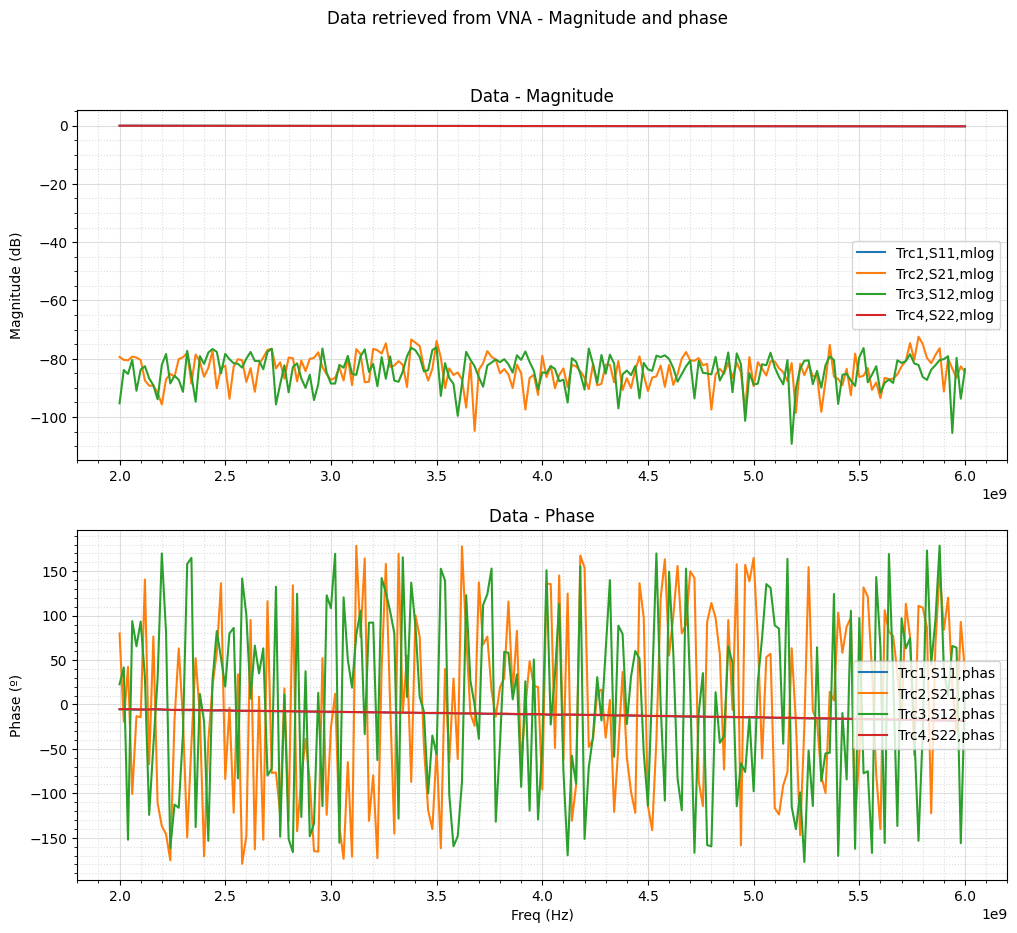

In [10]:
plot_measurement(meas)

# Create the matrix

In [41]:
meas = meas.T
np.shape(meas)

(201, 8)

In [42]:
freq = np.array([FREQ]).T
np.shape(freq)

(201, 1)

In [47]:
mat = np.concatenate((freq, meas), axis=1)
mat

array([[ 2.00000000e+09, -2.65736151e-02, -5.47005463e+00, ...,
         2.26800404e+01, -4.81269173e-02, -5.17622328e+00],
       [ 2.02000000e+09, -7.33333267e-03, -5.68029213e+00, ...,
         4.16837425e+01, -5.59914261e-02, -5.14605904e+00],
       [ 2.04000000e+09, -6.10952359e-03, -5.87972498e+00, ...,
        -1.52282181e+02, -5.93545400e-02, -5.12742424e+00],
       ...,
       [ 5.96000000e+09, -2.47301564e-01, -1.83459911e+01, ...,
         6.39488640e+01, -2.57597744e-01, -1.81349716e+01],
       [ 5.98000000e+09, -2.47026265e-01, -1.84343586e+01, ...,
        -1.56175552e+02, -2.56881565e-01, -1.83010368e+01],
       [ 6.00000000e+09, -2.46670365e-01, -1.85002232e+01, ...,
         1.56058912e+01, -2.48924747e-01, -1.83396759e+01]])